# 18/08/2022

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from utils.data_processing import get_dates_str, download_and_prepare_data, load_spread_btc_eth
from utils.kernels import Kernel
from utils.estimation import estimate_parameters_tvAR_p, forecast_future_values_tvAR_p 
from utils.interpolation import interpolate_and_extrapolate, plot_interpolation, extrapolate_parameters
from utils.trading import get_actions_and_forecasts, launch_trading_simulation1, launch_trading_simulation2, launch_trading_simulation3

sns.set_style("whitegrid")

In [2]:
def make_general_plots(time_series, p=1, k=3):
    # MODELLING
    u_list = np.linspace(0, 1, 100, endpoint=False)
    T = time_series.shape[0]
    b_T = 0.1 * T ** (-1/5)
    print(f"{T=}")
    print(f"{b_T=}")

    theta_hat = estimate_parameters_tvAR_p(time_series=time_series, p=p, u_list=u_list, kernel=Kernel("epanechnikov"), bandwidth=b_T)
    alpha_hat = theta_hat[:, :-1, :].squeeze(axis=2)
    sigma_hat = theta_hat[:, -1, :].squeeze()

    # PLOT DATA TIME SERIES + COEFFICIENTS TIME SERIES
    fig = plt.figure(constrained_layout=True)
    subfigs = fig.subfigures(3, 1)
    # spread time series
    ax = subfigs[0].subplots(1, 1)
    ax.plot(time_series)
    ax.set_title("Spread")
    # alpha
    axs = subfigs[1].subplots(1, p) if p > 1 else [subfigs[1].subplots(1, p)]
    for i in range(p):
        axs[i].plot(u_list, alpha_hat[:, i])
        axs[i].set_title(f"alpha_{i+1}")
    # sigma
    ax = subfigs[2].subplots(1, 1)
    ax.plot(u_list, sigma_hat)
    ax.set_title("sigma")

    # PLOT ACF / PACF
    fig2, axs2 = plt.subplots(1, 2)
    pacf_, conf_int = pacf(time_series, nlags=10, alpha=0.05)
    plot_pacf(time_series, method='ywm', ax=axs2[0], lags=np.arange(10), alpha=0.05, markersize=3)
    plot_acf(time_series, ax=axs2[1], lags=np.arange(10), alpha=0.05, markersize=3)

    # PLOT Interpolation for one coefficient
    fig, ax = plt.subplots()
    alpha_interpolation = interpolate_and_extrapolate(alpha_hat[:, 0], k=k)
    plot_interpolation(alpha_hat[:, 0], alpha_interpolation, ax)
    
    # PLOT forecast of the time series
    fig, ax = plt.subplots()
    alpha_extrapolated, sigma_extrapolated = extrapolate_parameters(alpha_hat, sigma_hat, num_points=10, interpol_step=1, n_forecasts=1, k=3) # shape (n_forecasts, alpha_hat.shape[1])
    preds = forecast_future_values_tvAR_p(alpha_extrapolated, time_series)
    ax.plot(np.arange(19, 20+len(preds)), np.concatenate([[time_series[-1]], preds]), color='red', label='prediction')
    ax.plot(np.arange(20), time_series[-20:], label='time series')
    ax.set_title("last 20 points of the time series + forecast")
    ax.legend()

def plot_rolling_entries(time_series, spread_time_series, n_forecasts=50, n_last_points=80, p=1, k=3):
    (actions, forecasts, z_list) = get_actions_and_forecasts(time_series=time_series, n_forecasts=n_forecasts, p=p, k=k)
    print(scipy.stats.spearmanr(time_series[-n_forecasts:], forecasts))
    
    # Plot figure
    ## time series and forecasts
    fig, ax = plt.subplots()
    x = np.arange(n_last_points)
    ax.plot(x, time_series[-n_last_points:])
    ax.plot(x[-n_forecasts:], forecasts, color='red', label='forecasts')
    ax.vlines(x[-n_forecasts], time_series[-n_last_points:].min(),
              time_series[-n_last_points:].max(), color='red', linestyle='--', label='forecasts begin here')
    ax.scatter(x[-n_forecasts + np.argwhere(actions == 'LONG')] - 1,
               time_series[-n_forecasts + np.argwhere(actions == 'LONG') - 1], marker='^', color='green', label='Open LONG')
    ax.scatter(x[-n_forecasts + np.argwhere(actions == 'SHORT') - 1],
               time_series[-n_forecasts + np.argwhere(actions == 'SHORT') - 1], marker='v', color='black', label='Open SHORT')
    ax.set_title(f"Trade Signals ({k=}, {p=})")
    ax.legend()
    ## spread time series
    fig, ax = plt.subplots()
    ax.plot(x, spread_time_series[-n_last_points:])
    ax.scatter(x[-n_forecasts + np.argwhere(actions == 'LONG')] - 1,
               spread_time_series[-n_forecasts + np.argwhere(actions == 'LONG') - 1], marker='^', color='green', label='Open LONG')
    ax.scatter(x[-n_forecasts + np.argwhere(actions == 'SHORT') - 1],
               spread_time_series[-n_forecasts + np.argwhere(actions == 'SHORT') - 1], marker='v', color='black', label='Open SHORT')
    ## z
    fig, ax = plt.subplots()
    ax.plot(x[-n_forecasts:], z_list, color='green', label='z')

## Trading strategies

### Assumptions

- No initial position
- No initial cash
- No transaction cost
- For each trade, volume = 1 (1 BTC and 1 ETH)

### Parameters

In [3]:
p = 1       # order of the tvAR(p)
k = 3       # order of the spline interpolation
T = 10_000  # length of each time series
n_simulations = 5000 # number of hours for the trading simulation

### Data

In [4]:
end_date = '2022-08-14' # '2022-08-14' max
start, end = get_dates_str(n_simulations + T - 1, end_date)
data_df = load_spread_btc_eth(start, end)

time_series = data_df['spread_log_returns'].to_numpy()
spread_time_series = data_df['spread'].to_numpy()

INFO:root:Data loaded from 2020-11-27 01:00:00 to 2022-08-14 00:00:00


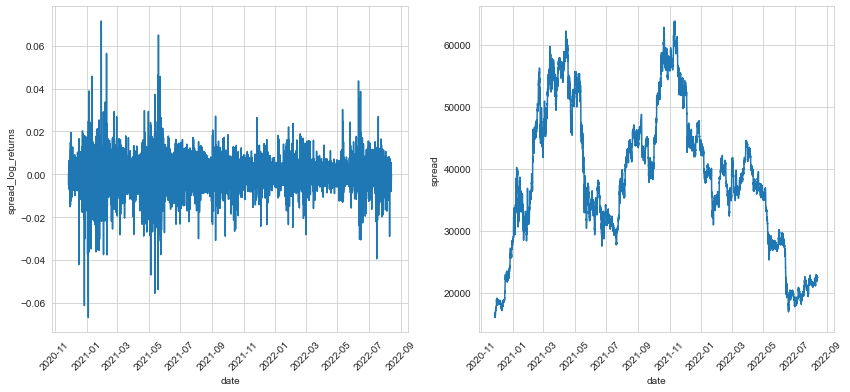

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(data=data_df, x=data_df.index, y="spread_log_returns", ax=axs[0]);
sns.lineplot(data=data_df, x=data_df.index, y="spread", ax=axs[1]);

for ax in axs.flat: ax.tick_params(axis='x', labelrotation=45)

### Strategy 1

- Open position at time $t$ if $|z| > z_*$
- Close position at time $t+1$

#### $z_* = 0$

INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000
step 5000 / 5000


INFO:root:Ratios: {'ratio': 0.4902, 'short ratio': 0.4955615592435353, 'long ratio': 0.48443337484433374}


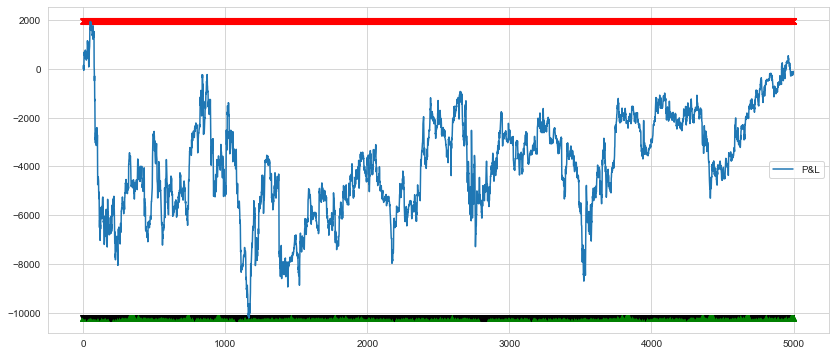

In [6]:
portfolio_1_z0 = launch_trading_simulation1(data_df, T, p, k, 0, f'strat1_n={n_simulations}_z0')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_1_z0.plot_pnl_entries(ax)

#### $z_* = 1$

INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000


INFO:root:Ratios: {'ratio': 0.5757575757575758, 'short ratio': 0.6451612903225806, 'long ratio': 0.5142857142857142}


step 5000 / 5000


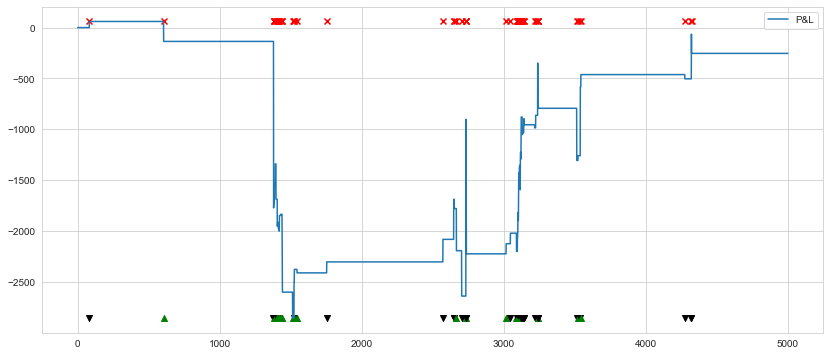

In [7]:
portfolio_1_z1 = launch_trading_simulation1(data_df, T, p, k, 1, f'strat1_n={n_simulations}_z1')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_1_z1.plot_pnl_entries(ax)

#### $z_* = 2$

INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000


INFO:root:Ratios: {'ratio': 0.21428571428571427, 'short ratio': 0.4, 'long ratio': 0.1111111111111111}


step 5000 / 5000


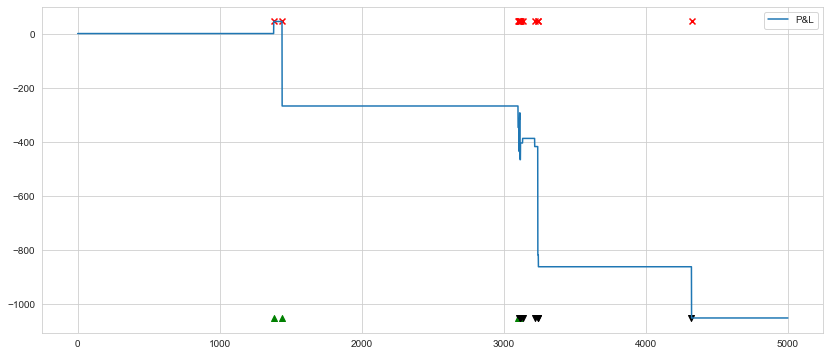

In [8]:
portfolio_1_z2 = launch_trading_simulation1(data_df, T, p, k, 2, f'strat1_n={n_simulations}_z2')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_1_z2.plot_pnl_entries(ax)

### Strategy 2

- Open position at time $t$ when $|z| > z_*$
- Close position at time $t'$ when the opposite signal is received

$z_* = 0$

INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000


INFO:root:Ratios: {'ratio': 0.48620876149269876, 'short ratio': 0.492972972972973, 'long ratio': 0.47943722943722944}


step 5000 / 5000


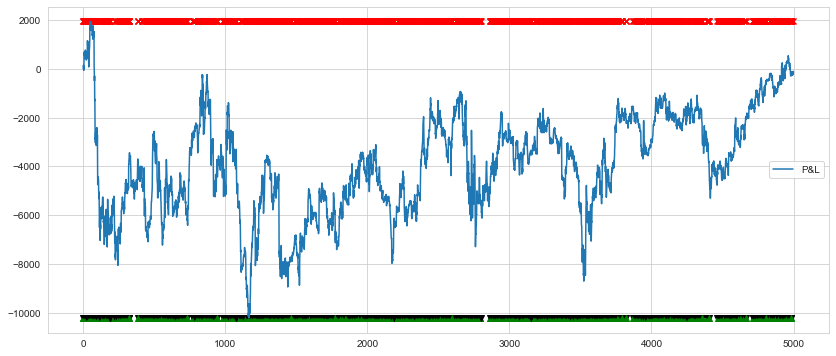

In [9]:
portfolio_2_z0 = launch_trading_simulation2(data_df, T, p, k, 0, f'strat2_n={n_simulations}_z0')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_2_z0.plot_pnl_entries(ax)

#### $z_* = 1$

INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000


INFO:root:Ratios: {'ratio': 0.6060606060606061, 'short ratio': 0.6875, 'long ratio': 0.5294117647058824}


step 5000 / 5000


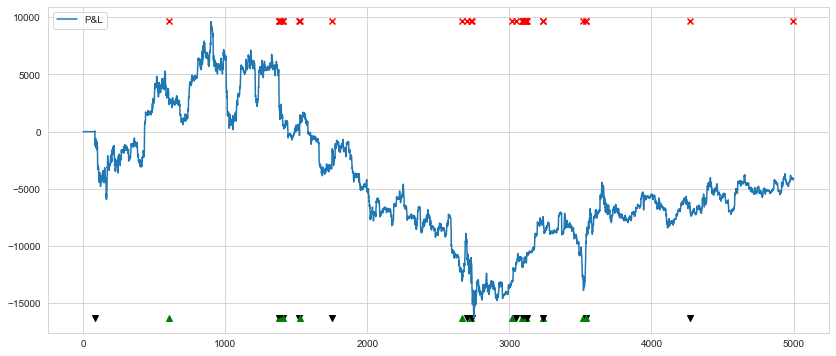

In [10]:
portfolio_2_z1 = launch_trading_simulation2(data_df, T, p, k, 1, f'strat2_n={n_simulations}_z1')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_2_z1.plot_pnl_entries(ax)

#### $z_* = 2$

INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000


INFO:root:Ratios: {'ratio': 0.25, 'short ratio': 0.5, 'long ratio': 0.0}


step 5000 / 5000


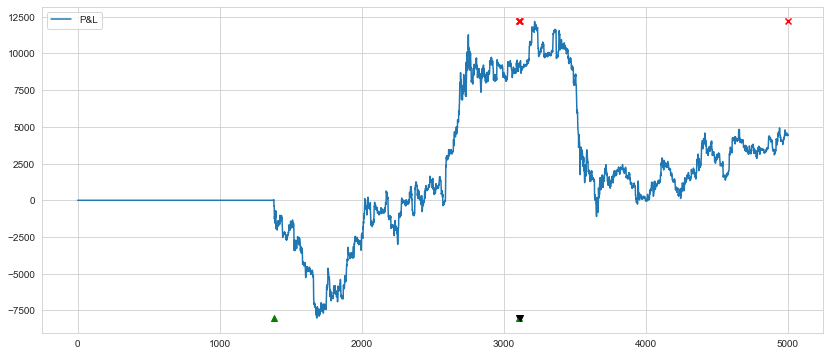

In [11]:
portfolio_2_z2 = launch_trading_simulation2(data_df, T, p, k, 2, f'strat2_n={n_simulations}_z2')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_2_z2.plot_pnl_entries(ax)

### Strategy 3

- Open position if $|z| > z_{*,1}$
- Close position if $|z| < z_{*, 2}$

#### $z_{*,1} = 0$ and $z_{*,2} = 0.25$

INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000


INFO:root:Ratios: {'ratio': 0.489137590520079, 'short ratio': 0.49441340782122906, 'long ratio': 0.48443337484433374}


step 5000 / 5000


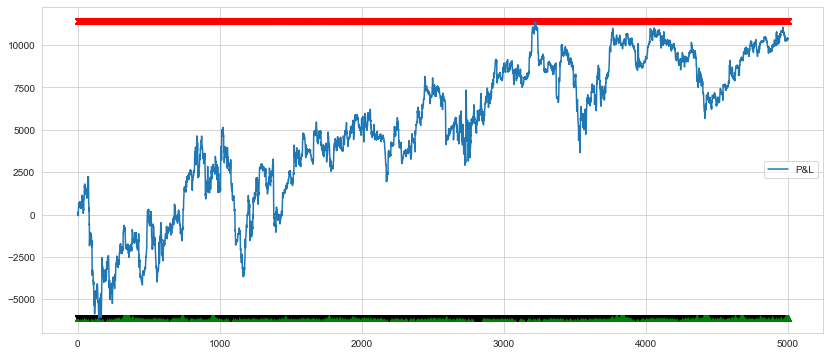

In [12]:
portfolio_3_z0 = launch_trading_simulation3(data_df, T, p, k, 0, 0.25, f'strat3_n={n_simulations}_z0')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_3_z0.plot_pnl_entries(ax)

#### $z_{*,1} = 1$ and $z_{*,2} = 0.25$

INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000


INFO:root:Ratios: {'ratio': 0.5576923076923077, 'short ratio': 0.6470588235294118, 'long ratio': 0.5142857142857142}


step 5000 / 5000


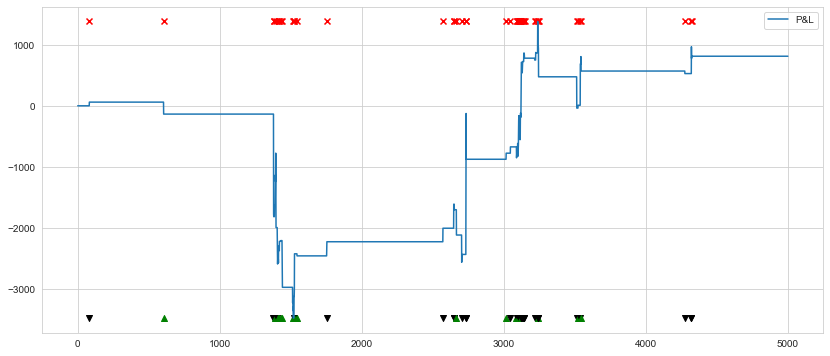

In [13]:
portfolio_3_z1 = launch_trading_simulation3(data_df, T, p, k, 1, 0.25, f'strat3_n={n_simulations}_z1')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_3_z1.plot_pnl_entries(ax)

#### $z_{*,1} = 2$ and $z_{*,2} = 0.25$


INFO:root:Simulation launched from 2022-01-17 17:00:00 to 2022-08-14 00:00:00 (5000 hours)


step 100 / 5000
step 200 / 5000
step 300 / 5000
step 400 / 5000
step 500 / 5000
step 600 / 5000
step 700 / 5000
step 800 / 5000
step 900 / 5000
step 1000 / 5000
step 1100 / 5000
step 1200 / 5000
step 1300 / 5000
step 1400 / 5000
step 1500 / 5000
step 1600 / 5000
step 1700 / 5000
step 1800 / 5000
step 1900 / 5000
step 2000 / 5000
step 2100 / 5000
step 2200 / 5000
step 2300 / 5000
step 2400 / 5000
step 2500 / 5000
step 2600 / 5000
step 2700 / 5000
step 2800 / 5000
step 2900 / 5000
step 3000 / 5000
step 3100 / 5000
step 3200 / 5000
step 3300 / 5000
step 3400 / 5000
step 3500 / 5000
step 3600 / 5000
step 3700 / 5000
step 3800 / 5000
step 3900 / 5000
step 4000 / 5000
step 4100 / 5000
step 4200 / 5000
step 4300 / 5000
step 4400 / 5000
step 4500 / 5000
step 4600 / 5000
step 4700 / 5000
step 4800 / 5000
step 4900 / 5000


INFO:root:Ratios: {'ratio': 0.15384615384615385, 'short ratio': 0.25, 'long ratio': 0.1111111111111111}


step 5000 / 5000


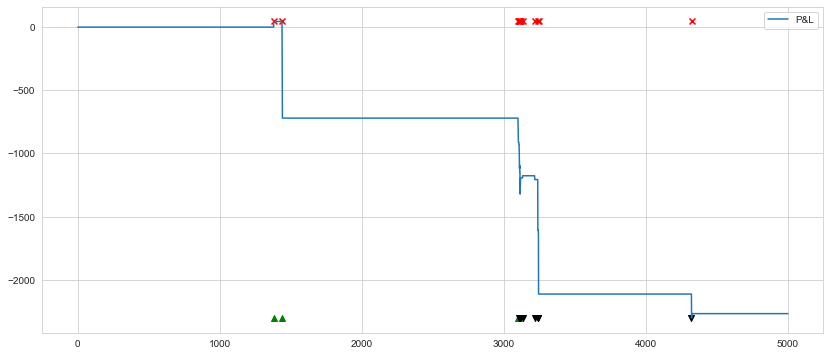

In [14]:
portfolio_3_z2 = launch_trading_simulation3(data_df, T, p, k, 2, 0.25, f'strat3_n={n_simulations}_z2')

fig, ax = plt.subplots(figsize=(14, 6))
portfolio_3_z2.plot_pnl_entries(ax)